# Import Modules

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import tensorflow as tf

from datetime import datetime
from keras.layers import Dense
from keras.models import Sequential
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import chi2
from sklearn.feature_selection import r_regression, SelectKBest
from sklearn.feature_selection import r_regression, SelectPercentile
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils._testing import ignore_warnings
from tensorflow import keras
from keras.callbacks import TensorBoard
from tabulate import tabulate
from xgboost import XGBClassifier

%matplotlib inline


2022-11-25 08:40:45.479274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install gdown

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.


In [3]:
pd.set_option('display.show_dimensions', True)
pd.set_option('display.max_columns', 200)


# Load Data

In [4]:
df = pd.read_csv('~/Downloads/credit card payments.csv')

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Categorical Encoding

In [6]:
# create a dataframe copy just for feature selection
df_fs = df.copy(deep=True)

# encode the categorical data
cat_cols = [col for col in df_fs.columns if df_fs[col].dtype == 'object']
print(cat_cols)
oe = OrdinalEncoder()
df_fs[cat_cols] = oe.fit_transform(df_fs[cat_cols])

[]


In [7]:
df.shape

(284807, 31)

There is no categorical features in this dataset. We will proceed forward using the original dataframe (df).

# Feature Selection

## Drop Useless Features

In [8]:
x = df.drop('Class', axis=1)
y = df['Class']

In [9]:
# create this empty set to collect only the selected features later
features = set()

## Lasso Model

In [10]:
reg = LassoCV()
reg.fit(x, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(x, y))
coef = pd.Series(reg.coef_, index=x.columns)

Best alpha using built-in LassoCV: 0.024301
Best score using built-in LassoCV: 0.000177


In [11]:
print("Lasso picked " + str(sum(coef != 0)) +
      " variables and eliminated the other " + str(sum(coef == 0)) + " variables.")

Lasso picked 2 variables and eliminated the other 28 variables.


Text(0.5, 1.0, 'Feature importance using Lasso Model')

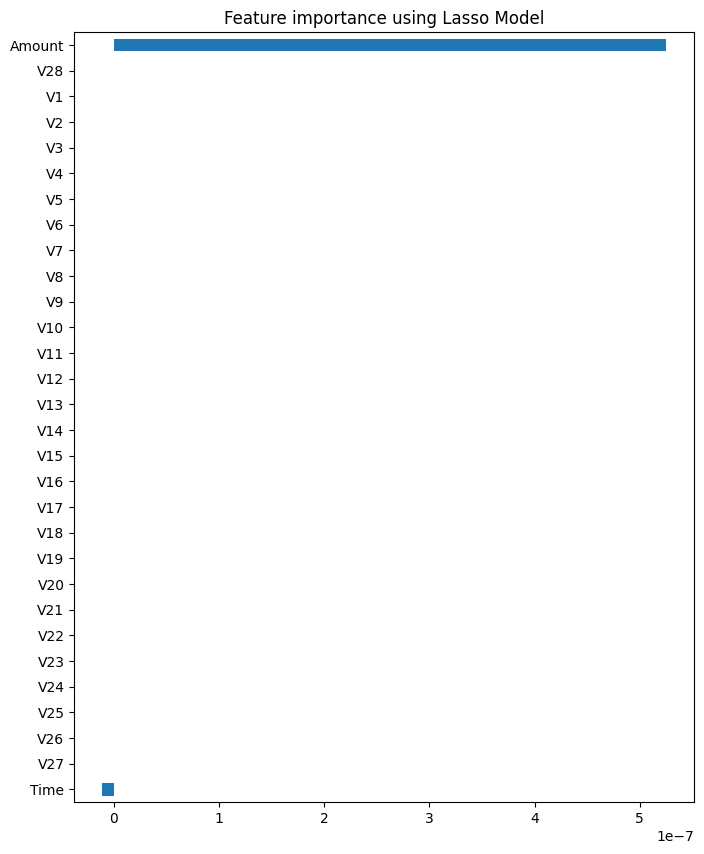

In [12]:
imp_coef = coef.sort_values()
mpl.rcParams['figure.figsize'] = (8, 10)
imp_coef.plot(kind="barh")
plt.title("Feature importance using Lasso Model")


In [13]:
for item in imp_coef[imp_coef != 0].index.tolist():
    print(f'Adding {item}.')
    features.add(item)

Adding Time.
Adding Amount.


## Chi-square

In [14]:
# x contains negative values that cannot be used for chi2
# let's normalize x
scalar = MinMaxScaler()
x_chi = scalar.fit_transform(x)
chi_scores = chi2(x_chi, y)

<AxesSubplot:>

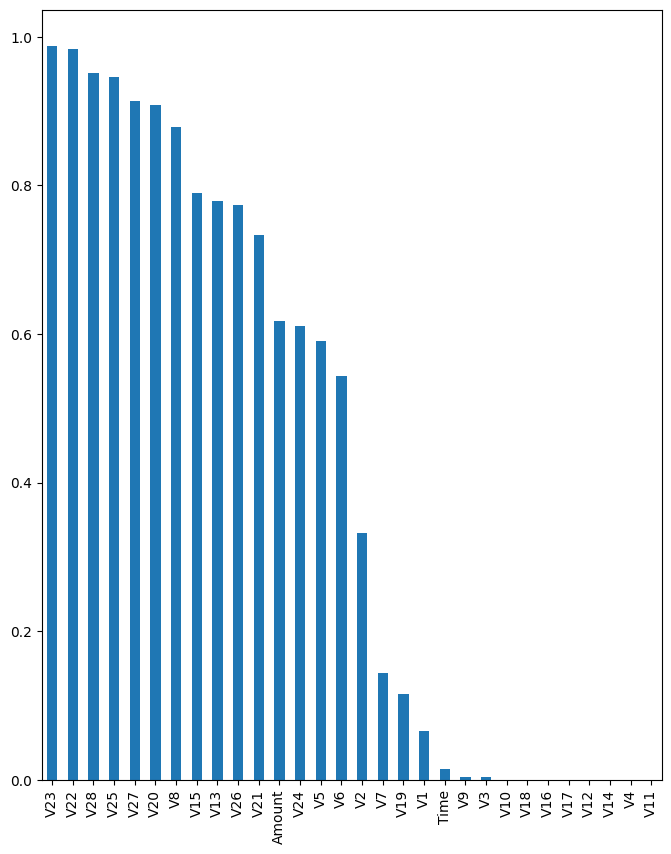

In [15]:
# extract and plot the p-values
p_values = pd.Series(chi_scores[1], index=x.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()

In [16]:
for item in p_values[p_values > 0.001].index.tolist():
    print(f'Adding {item}.')
    features.add(item)

Adding V23.
Adding V22.
Adding V28.
Adding V25.
Adding V27.
Adding V20.
Adding V8.
Adding V15.
Adding V13.
Adding V26.
Adding V21.
Adding Amount.
Adding V24.
Adding V5.
Adding V6.
Adding V2.
Adding V7.
Adding V19.
Adding V1.
Adding Time.
Adding V9.
Adding V3.


## ANOVA f-value

<AxesSubplot:>

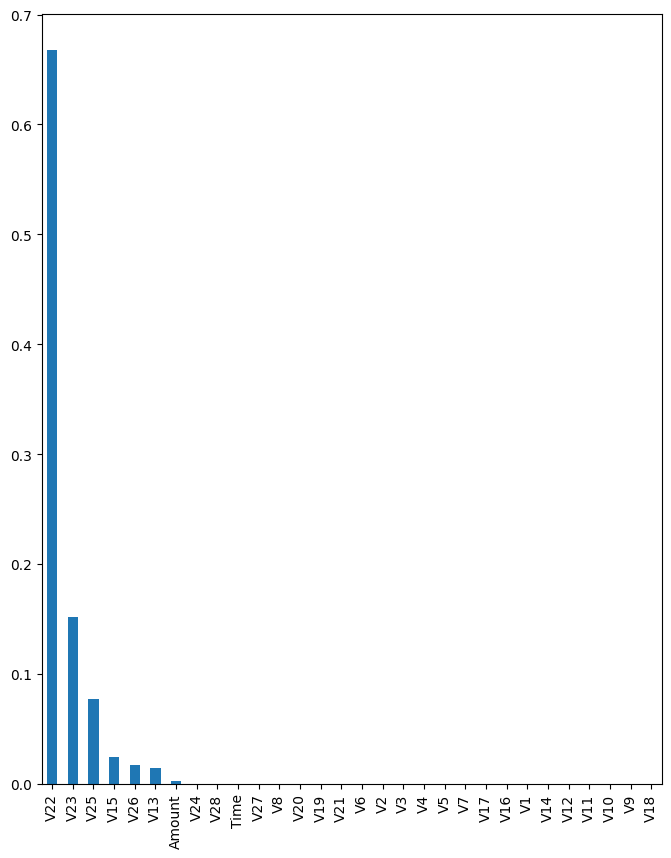

In [17]:
f_scores = f_regression(x, y)
# extract and plot the p-values
p_values = pd.Series(f_scores[1], index=x.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()

In [18]:
for item in p_values[p_values > 0.0001].index.tolist():
    print(f'Adding {item}.')
    features.add(item)

Adding V22.
Adding V23.
Adding V25.
Adding V15.
Adding V26.
Adding V13.
Adding Amount.
Adding V24.


## Selected Features

In [19]:
print(f'These are the selected features: {features}.')

These are the selected features: {'V19', 'V23', 'V2', 'V24', 'V26', 'V28', 'Amount', 'V6', 'Time', 'V8', 'V3', 'V20', 'V7', 'V15', 'V13', 'V1', 'V27', 'V21', 'V25', 'V9', 'V22', 'V5'}.


In [20]:
# categorical encoded columns + selected features only
x = df[list(features)]
y = df['Class']

# Machine Learning

In [21]:
sc = StandardScaler()
x = sc.fit_transform(x)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

In [23]:
@ignore_warnings(category=ConvergenceWarning)
class ClassifierModels():
    def __init__(self, df, x, y, x_test, y_test):
        '''Init function. Make sure to pass x_train and y_train here.'''

        self.df = df
        self.x = x
        self.y = y
        self.x_test = x_test
        self.y_test = y_test
        
        print('#' * 60)
        print(f'{" Loading dataframe ":#^60}')
        print('#' * 60)
        print(f'{" Getting best parameters to create our models ":#^60}')
        print('#' * 60)

        # hold abbreviations and full names
        self.model_abr = {
            'lr': 'Logistic Regression',
            'knn': 'KNeighbors Classifier',
            # 'svm': 'Support Vector Machine',
            'dtc': 'Decision Tree Classifier',
            'rfc': 'Random Forest Classifier',
            'ensemble': 'Voting Classifier',
            'xgb': 'XGB Classifier',
            'nb': 'Naive Bayes'
            }

        # hold the actual models
        self.models = {}
        self.model_predicts = {}
        self.model_predicts_proba = {}

        # loop over the models dict to get each model's best params
        for model in self.model_abr:
            print('#' * 60)
            print(f'{" " + self.model_abr[model] + " ":#^60}')
            print('#' * 60)
            # params = self.get_best_params(model)

            # print('+++++ Best parameters for the {} model: {}'.format(
            #     self.model_abr[model], params))
            print('+++++ Creating and fitting the {} model using its default parameters...'.format(
                self.model_abr[model]))

            if model == 'lr':
                # m = LogisticRegression(
                #     solver=params['solver'],
                #     penalty=params['penalty'],
                #     C=params['C']
                #     )
                m = LogisticRegression(n_jobs=-1)
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'knn':
                # m = KNeighborsClassifier(
                #     n_neighbors=params['n_neighbors'],
                #     weights=params['weights'],
                #     metric=params['metric']
                #     )
                m = KNeighborsClassifier(n_jobs=-1)
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'svm':
                # m = SVC(
                #     kernel=params['kernel'],
                #     C=params['C'],
                #     gamma=params['gamma'],
                #     probability=True
                #     )
                m = SVC(probability=True)
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'dtc':
                # m = DecisionTreeClassifier(
                #     criterion=params['criterion'],
                #     splitter=params['splitter'],
                #     max_features=params['max_features']
                #     )
                m = DecisionTreeClassifier()
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'rfc':
                # m = RandomForestClassifier(
                #     n_estimators=params['n_estimators'],
                #     max_features=params['max_features']
                #     )
                m = RandomForestClassifier(n_jobs=-1)
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'ensemble':
                m = VotingClassifier(
                    estimators=[
                        ('Logistic Regression', self.models['lr']),
                        ('Decission Tree Classifier', self.models['dtc']),
                        ('Random Forrest Classifier', self.models['rfc']),
                        ('KNN', self.models['knn'])
                        # ('SVM', self.models['svm'])
                        ],
                    # weights=[10, 10, 10, 10, 10],
                    weights=[10, 10, 10, 10],
                    voting='soft', 
                    n_jobs=-1)
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'xgb':
                m = XGBClassifier(use_label_encoder=False)
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'nb':
                m = GaussianNB()
                m.fit(self.x, self.y)

                self.models[model] = m

        print('#' * 60)
        print(f'{" All models created and fitted successfully! ":#^60}')
        print('#' * 60)

        # loop over the models and get the y_pred
        for model in self.model_abr:
            y_pred = self.models[model].predict(self.x_test)

            self.model_predicts[model] = y_pred
        
        print('#' * 60)
        print(f'{" All y_preds created successfully! ":#^60}')
        print('#' * 60)

        # loop over the models and get the y_pred_proba
        for model in self.model_abr:
            y_pred_proba = self.models[model].predict_proba(self.x_test)

            self.model_predicts_proba[model] = y_pred_proba
        
        print('#' * 60)
        print(f'{" All y_pred_probas created successfully! ":#^60}')
        print('#' * 60)

    @ignore_warnings(category=ConvergenceWarning)
    def get_best_params(self, model):
        '''This method returns the best params for hypertuning each model'''

        if model == 'lr':
            # model
            lr_model = LogisticRegression()

            # params
            solver = ['newton-cg', 'lbfgs', 'liblinear']
            penalty = ['l2']
            C = [100, 10, 1.0, 0.1, 0.01]
            lr_params = dict(solver=solver, penalty=penalty, C=C)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=1, random_state=1)
            lr_gsearch = GridSearchCV(
                estimator=lr_model,
                param_grid=lr_params,
                cv=cv,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            lr_gresult = lr_gsearch.fit(self.x, self.y)

            return lr_gresult.best_params_

        elif model == 'knn':
            # model
            knn_model = KNeighborsClassifier()

            # params
            n_neighbors = [100000]
            weights = ['uniform', 'distance']
            metric = ['euclidean', 'manhattan', 'minkowski']
            knn_params = dict(n_neighbors=n_neighbors,
                              weights=weights, metric=metric)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=1, random_state=1)
            knn_gsearch = GridSearchCV(
                estimator=knn_model,
                param_grid=knn_params,
                cv=cv,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            knn_gresult = knn_gsearch.fit(self.x, self.y)

            return knn_gresult.best_params_

        elif model == 'svm':
            # model
            svm_model = SVC()

            # params
            kernel = ['poly', 'rbf', 'sigmoid']
            C = [50, 10, 1.0, 0.1, 0.01]
            gamma = ['scale']
            svm_params = dict(kernel=kernel, C=C, gamma=gamma)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=1, random_state=1)
            svm_gsearch = GridSearchCV(
                estimator=svm_model,
                param_grid=svm_params,
                cv=None,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            svm_gresult = svm_gsearch.fit(self.x, self.y)

            return svm_gresult.best_params_

        elif model == 'dtc':
            # model
            dtc_model = DecisionTreeClassifier()

            # params
            criterion = ['gini', 'entropy']
            splitter = ['best', 'random']
            max_features = ['sqrt', 'log2', None]
            dtc_params = dict(criterion=criterion,
                              splitter=splitter, max_features=max_features)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=1, random_state=1)
            dtc_gsearch = GridSearchCV(
                estimator=dtc_model,
                param_grid=dtc_params,
                cv=None,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            dtc_gresult = dtc_gsearch.fit(self.x, self.y)

            return dtc_gresult.best_params_

        elif model == 'rfc':
            # model
            rfc_model = RandomForestClassifier()

            # params
            n_estimators = [10, 100, 1000]
            max_features = ['sqrt', 'log2']
            rfc_params = dict(n_estimators=n_estimators,
                              max_features=max_features)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=1, random_state=1)
            rfc_gsearch = GridSearchCV(
                estimator=rfc_model,
                param_grid=rfc_params,
                cv=None,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            rfc_gresult = rfc_gsearch.fit(self.x, self.y)

            return rfc_gresult.best_params_

        elif model == 'ensemble':
            return

        elif model == 'xgb':
            return

        elif model == 'nb':
            return

        else:
            raise NameError(
                'No grid search model available for {}.'.format(model))

    def show_performance(self):
        '''This method prints the accuracy, precision, recall, and f1 score for each model.'''

        headers = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        tbldata = []
        for model in self.models:
            accuracy = metrics.accuracy_score(
                self.y_test, self.model_predicts[model])
            f1score = metrics.f1_score(
                self.y_test, self.model_predicts[model], average='weighted', zero_division=0)
            precision = metrics.precision_score(
                self.y_test, self.model_predicts[model], average='weighted', zero_division=0)
            recall = metrics.recall_score(
                self.y_test, self.model_predicts[model], average='weighted', zero_division=0)

            tbldata.append([self.model_abr[model], accuracy,
                           precision, recall, f1score])

        return tabulate(tbldata, headers=headers, tablefmt="pretty")

In [24]:
cm = ClassifierModels(df[list(features)], x_train, y_train, x_test, y_test)

############################################################
#################### Loading dataframe #####################
############################################################
####### Getting best parameters to create our models #######
############################################################
############################################################
################### Logistic Regression ####################
############################################################
+++++ Creating and fitting the Logistic Regression model using its default parameters...
############################################################
################## KNeighbors Classifier ###################
############################################################
+++++ Creating and fitting the KNeighbors Classifier model using its default parameters...
############################################################
################# Decision Tree Classifier #################
###########################

/Users/sergani/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


############################################################
####################### Naive Bayes ########################
############################################################
+++++ Creating and fitting the Naive Bayes model using its default parameters...
############################################################
####### All models created and fitted successfully! ########
############################################################
############################################################
############ All y_preds created successfully! #############
############################################################
############################################################
######### All y_pred_probas created successfully! ##########
############################################################


## Model Performance

In [25]:
print('Performance of the different models:\n', cm.show_performance(), sep='')

Performance of the different models:
+--------------------------+--------------------+--------------------+--------------------+--------------------+
|                          |      Accuracy      |     Precision      |       Recall       |      F1 Score      |
+--------------------------+--------------------+--------------------+--------------------+--------------------+
|   Logistic Regression    | 0.9988413328183702 | 0.9986952991551427 | 0.9988413328183702 | 0.9986707379255078 |
|  KNeighbors Classifier   | 0.9992275552122467 | 0.9991962687061994 | 0.9992275552122467 | 0.9991381936699711 |
| Decision Tree Classifier | 0.9981039991573329 | 0.9982156797393276 | 0.9981039991573329 | 0.9981570580154479 |
| Random Forest Classifier | 0.9989993328885924 | 0.998933963040046  | 0.9989993328885924 | 0.9988393108331274 |
|    Voting Classifier     | 0.9990695551420246 | 0.9990372405472858 | 0.9990695551420246 | 0.9989207627044867 |
|      XGB Classifier      | 0.9991924440855307 | 0.9991394

### ROC

Text(0.5, 1.0, 'ROC Curves for Models')

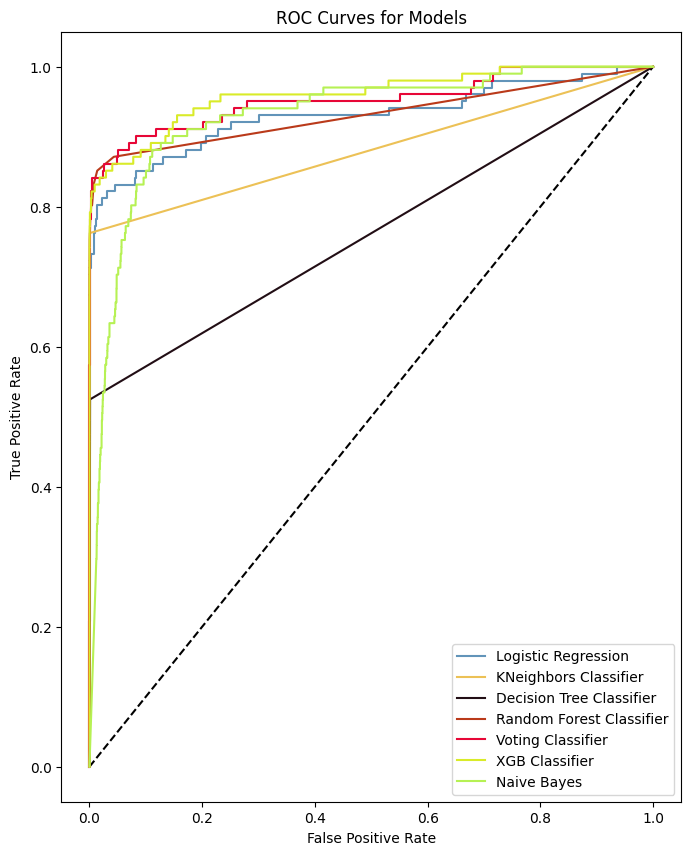

In [26]:
# collect the ROC results
roc_results = {}

for model in cm.model_abr:
    fpr, tpr, thresholds = roc_curve(
        cm.y_test, cm.model_predicts_proba[model][:, 1])

    roc_results[model] = [fpr, tpr, thresholds]

# graph the ROC of all of the models
fig, ax0 = plt.subplots()

ax0.plot([0, 1], [0, 1], 'k--')
for model in roc_results:
    ax0.plot(roc_results[model][0],
             roc_results[model][1], c=np.random.rand(3,), label=cm.model_abr[model])
ax0.set_xlabel('False Positive Rate')
ax0.set_ylabel('True Positive Rate')

ax0.legend()
ax0.set_title('ROC Curves for Models')

### AUC

In [27]:
# table headers and a dictionary to hold the values
headers = ['AUC']
tbl_data_dict = {}

# loop over the classifier models and then their keys abbreviated keys
for k in cm.model_abr:
    auc = roc_auc_score(cm.y_test, cm.model_predicts_proba[k][:, 1])
    tbl_data_dict.setdefault(cm.model_abr[k], []).append(auc)

# create the table data from the dictionary created above
# tabulate doesn't take table data in the form of dictionary created above
tbldata = []
for k, v in tbl_data_dict.items():
    tbldata.append([k] + v)

print(tabulate(tbldata, headers=headers, tablefmt='pretty'))


+--------------------------+--------------------+
|                          |        AUC         |
+--------------------------+--------------------+
|   Logistic Regression    | 0.9302291970988487 |
|  KNeighbors Classifier   | 0.8810500367319228 |
| Decision Tree Classifier | 0.7618486352249301 |
| Random Forest Classifier | 0.9317759601710685 |
|    Voting Classifier     | 0.9526559556995076 |
|      XGB Classifier      | 0.9603173345596462 |
|       Naive Bayes        | 0.929237722491934  |
+--------------------------+--------------------+


# Deep Learning

In [28]:
%load_ext tensorboard

# create folders
now = datetime.now().strftime('%Y%m%d%H%M')
log_folder = f'Tensorboard Logs/Classification - Credit Card Payments {now}'

# callbacks for TensorBoard
callbacks = TensorBoard(log_dir=log_folder, histogram_freq=1)

In [29]:
x_dl = df.drop('Class', axis=1).values
y_dl = df['Class'].values

# # categorical encoded columns + selected features only
# x = df[list(features)]
# y = df['Class']


In [30]:
# clear previous sessions
keras.backend.clear_session()

# create keras model
model = keras.models.Sequential([
    keras.layers.Dense(6, activation='relu', input_dim=x_dl.shape[1]),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # in case of multiple classification use more perceptrons and softmax
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 186       
                                                                 
 dense_1 (Dense)             (None, 3)                 21        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


2022-11-25 08:43:04.465351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
sc = StandardScaler()
x_scaled = sc.fit_transform(x_dl)

model.compile(optimizer='Adam', loss='BinaryCrossentropy',
              metrics=['AUC', 'Precision', 'Recall'])

# this model shows 'vanishing gradient' behavior; loss doesn't change after a few epochs
model.fit(x=x_scaled, y=y_dl, validation_split=0.2,
          epochs=50, callbacks=callbacks)

Epoch 1/50
7121/7121 [==============================] - 12s 2ms/step - loss: 0.1656 - auc: 0.8619 - precision: 0.0618 - recall: 0.5372 - val_loss: 0.0193 - val_auc: 0.9260 - val_precision: 1.0000 - val_recall: 0.4000
Epoch 2/50
7121/7121 [==============================] - 9s 1ms/step - loss: 0.0091 - auc: 0.9294 - precision: 0.8638 - recall: 0.5779 - val_loss: 0.0042 - val_auc: 0.9260 - val_precision: 1.0000 - val_recall: 0.4667
Epoch 3/50
7121/7121 [==============================] - 9s 1ms/step - loss: 0.0046 - auc: 0.9372 - precision: 0.8615 - recall: 0.6115 - val_loss: 0.0031 - val_auc: 0.9262 - val_precision: 0.8305 - val_recall: 0.6533
Epoch 4/50
7121/7121 [==============================] - 9s 1ms/step - loss: 0.0039 - auc: 0.9372 - precision: 0.8692 - recall: 0.6691 - val_loss: 0.0030 - val_auc: 0.9196 - val_precision: 0.9375 - val_recall: 0.6000
Epoch 5/50
7121/7121 [==============================] - 9s 1ms/step - loss: 0.0034 - auc: 0.9456 - precision: 0.8780 - recall: 0.6906 -